# Analyzing The Min Norm Perturbation Necessary
I take a look at the matrix of minimum norm perturbation per electrode per time window for each patient and analyze its distribution and perform other data analyses to determine if there is a difference between EZ electrodes and non-EZ electrodes.

# Table of Contents:
Given a patient, time periods, and certain channels, we can explore the eigenspectrum, adjacency matrix and raw iEEG data.

* Import And Analyze Data <a href='#section1'>Link</a>
* Raw iEEG Data <a href='#section2'>Link</a>


In [5]:
import pandas as pd
import numpy as np
import json
import os
from IPython.display import display

import scipy, scipy.io


import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable
# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')
from natsort import natsorted, ns

%matplotlib inline


## sklearn imports
import sklearn.linear_model
import sklearn.cross_validation
import sklearn.tree
import sklearn.ensemble
import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.pipeline
import sklearn.grid_search

In [6]:
# paramaters of data
freq = 1000
winSize = 500
stepSize = 500

# directories
threshold = 0.8
radius = 1.5
perturbation = 'R'
patients = ['pt1sz2', 'pt1sz3', 'pt2sz1', 'pt2sz3', 'JH105sz1', 'JH102sz1', 'JH102sz3', 'JH102sz2', 'JH102sz4',\
           'JH102sz5', 'JH102sz6']
dataDir = '../adj_mats_win500_step500_freq1000/'

In [7]:
def determineClinicalAnnotations(patient_id, seizure_id):
    if patient_id == 'EZT005':
        included_channels = np.concatenate((np.arange(1,21+1), np.arange(23,60+1), np.arange(63,88+1)))
        ezone_labels = ['U4', 'U3', 'U5', 'U6', 'U8', 'U7'] 
        earlyspread_labels = []
        latespread_labels = []
    elif patient_id == 'EZT007':
        included_channels = np.concatenate((np.arange(1,16+1), np.arange(18,53+1), np.arange(55,71+1), \
                                           np.arange(74,78+1), np.arange(81,94+1)))
        ezone_labels = ['O7', 'E8', 'E7', 'I5', 'E9', 'I6', 'E3', 'E2',\
            'O4', 'O5', 'I8', 'I7', 'E10', 'E1', 'O6', 'I1', 'I9', 'E6',\
            'I4', 'O3', 'O2', 'I10', 'E4', 'Y1', 'O1', 'I3', 'I2'] 
        earlyspread_labels = []
        latespread_labels = []
    elif patient_id == 'EZT019':
        included_channels = np.concatenate((np.arange(1,5+1), np.arange(7,22+1), np.arange(24,79+1)))
        ezone_labels = ['I5', 'I6', 'B9', 'I9', 'T10', 'I10', 'B6', 'I4', \
            'T9', 'I7', 'B3', 'B5', 'B4', 'I8', 'T6', 'B10', 'T3',\
            'B1', 'T8', 'T7', 'B7', 'I3', 'B2', 'I2', 'T4', 'T2'] 
        earlyspread_labels = []
        latespread_labels = []
    elif patient_id == 'EZT045':
        included_channels = np.concatenate((np.arange(1,2), np.arange(3,14+1), np.arange(16,20+1), np.arange(24,38+1), \
                                           np.arange(30,65+1)))
        ezone_labels = ['X2', 'X1']
        earlyspread_labels = []
        latespread_labels = [] 
    elif patient_id == 'EZT090':
        included_channels = np.concatenate((np.arange(1,25+1), np.arange(27,42+1), np.arange(44,49+1), np.arange(51,73+1), \
                                           np.arange(75,90+1), np.arange(95, 111+1)))
        ezone_labels = ['N2', 'N1', 'N3', 'N8', 'N9', 'N6', 'N7', 'N5'] 
        earlyspread_labels = []
        latespread_labels = []
    elif patient_id == 'pt1':
        included_channels = np.concatenate((np.arange(1,36+1), np.arange(42, 43+1), \
                                            np.arange(46,69+1), np.arange(72,95+1)))
        ezone_labels = ['POLATT1', 'POLATT2', 'POLAD1', 'POLAD2', 'POLAD3']
        earlyspread_labels = ['POLATT3', 'POLAST1', 'POLAST2']
        latespread_labels = ['POLATT4', 'POLATT5', 'POLATT6', \
                            'POLSLT2', 'POLSLT3', 'POLSLT4', \
                            'POLMLT2', 'POLMLT3', 'POLMLT4', 'POLG8', 'POLG16']
    elif patient_id == 'pt2':
        included_channels = np.concatenate((np.arange(1,14+1), np.arange(16,19+1), np.arange(21,25+1), np.arange(27,37+1), \
                                           np.arange(43,44+1), np.arange(47,74+1)))
        ezone_labels = ['POLMST1', 'POLPST1', 'POLTT1']
        earlyspread_labels = ['POLTT2', 'POLAST2', 'POLMST2', 'POLPST2', 'POLALEX1', 'POLALEX5']
        latespread_labels = [];
        
    elif patient_id == 'pt7':
        included_channels = np.concatenate((np.arange(1,17+1), np.arange(19,35+1), np.arange(37,38+1), np.arange(41,62+1), \
                                           np.arange(67,109+1)))
        ezone_labels = []
        earlyspread_labels = []
        latespread_labels = []
    elif patient_id == 'JH105':
        included_channels = np.concatenate((np.arange(1,4+1), np.arange(7,12+1), np.arange(14,19+1), np.arange(21,37+1), \
                                          np.arange(42,43+1), np.arange(46,49+1), np.arange(51, 53+1), \
                                          np.arange(55, 75+1), np.arange(78, 99+1)))
        ezone_labels = ['POLRPG4', 'POLRPG5', 'POLRPG6', 'POLRPG12', 'POLRPG13',\
            'POLAPD1', 'POLAPD2', 'POLAPD3', 'POLAPD4', 'POLAPD5', 'POLAPD6', 'POLAPD7', 'POLAPD8', \
            'POLPPD1', 'POLPPD2', 'POLPPD3', 'POLPPD4', 'POLPPD5', 'POLPPD6', 'POLPPD7', 'POLPPD8', \
            'POLASI3', 'POLPSI5', 'POLPSI6', 'POLPDI2']
        earlyspread_labels = []
        latespread_labels = []
        
    elif patient_id == 'JH102':
        included_channels = np.concatenate((np.arange(1,12+1), np.arange(14,36+1), np.arange(41,42+1), np.arange(45,62+1), \
                                           np.arange(66,123+1)))
        ezone_labels = ['POLRAT1', 'POLRAT2']
        if seizure_id == 'sz3' or seizure_id == 'sz6':
            ezone_labels = ['POLLBT1', 'POLLBT2', 'POLLBT3', \
                'POLLAT1', 'POLLAT2', 'POLLAT3']
        earlyspread_labels = []
        latespread_labels = []
    
    return included_channels, ezone_labels, earlyspread_labels, latespread_labels

In [8]:
def loadLabels(patient):
    dataDir = '../data/'

    # create path to file for each different patient-seizure
    patFile = os.path.join(dataDir, patient, patient) 
    
    # load in the eeg and labels
    data = scipy.io.loadmat(patFile, squeeze_me=True, struct_as_record=False)
    eeg = data['data']
    elec_labels = data['elec_labels']
    
    return elec_labels

IOError: [Errno 2] No such file or directory: '../adj_mats_win500_step500_freq1000/R_finaldata_radius1.5/JH102sz1final_data.mat'

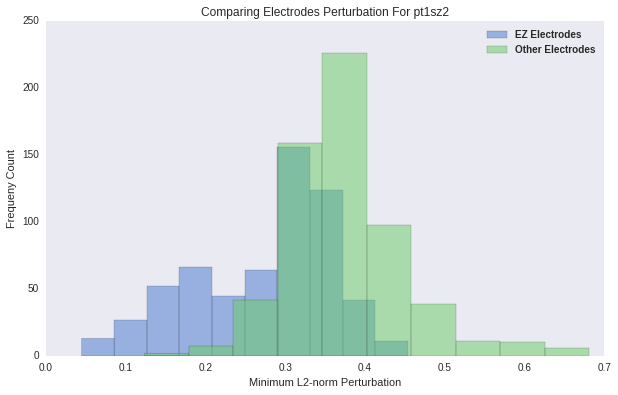

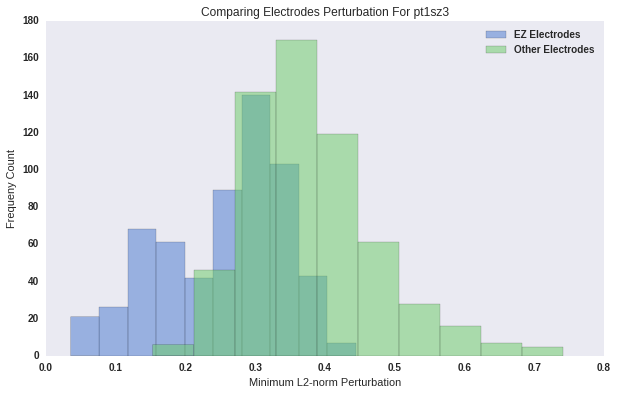

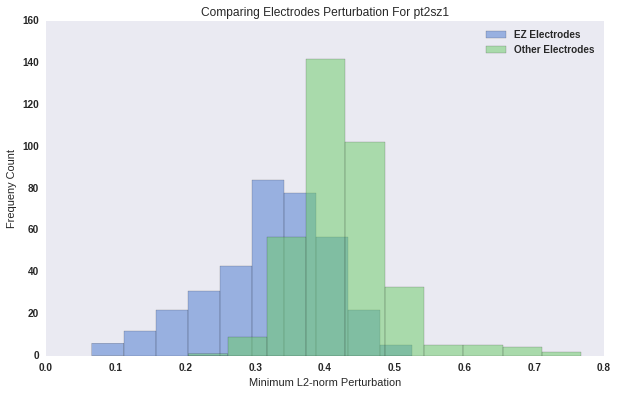

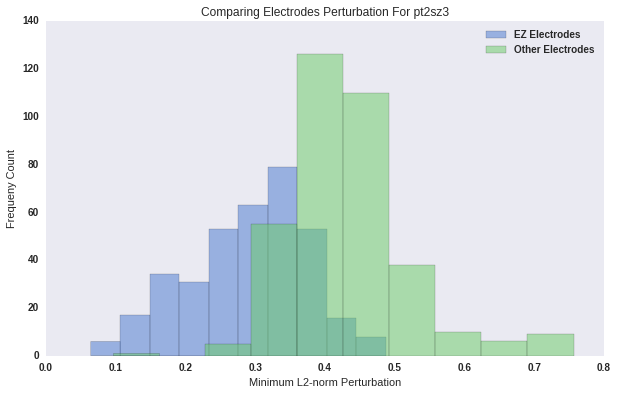

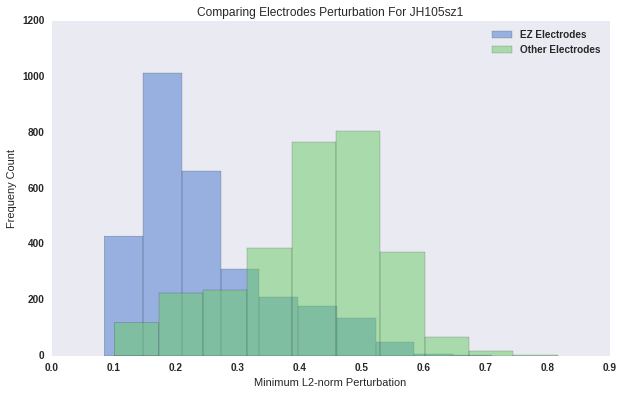

In [12]:
statsCompareList = [] # list to store the statistical test comparing ez to non-ez for each patient

for patient in patients:
    contrastStatList = [] # initialize empty list per patient
    
    # set directory path to the datafile and load it
    perturbationDir = os.path.join(dataDir, perturbation+'_finaldata_radius'+str(radius))
    dataFile = os.path.join(perturbationDir, patient+'final_data.mat')
    data = scipy.io.loadmat(dataFile, squeeze_me=True, struct_as_record=False)
    
    # load in the includedchannels, ezlabels, earlyspread/latespread labels
    try:
        pat_id = patient.split('seiz')[0]
        seiz_id = patient.split('seiz')[1]
    except:
        pat_id = patient.split('sz')[0]
        seiz_id = patient.split('sz')[1]
        
    included_channels, ezone_labels, earlyspread_labels, latespread_labels = determineClinicalAnnotations(pat_id, seiz_id)
    
    # load electrode labels of this patient
    elec_labels = loadLabels(patient)
    elec_indices = np.arange(0, len(elec_labels))

    # find indices of the ez labels and the ones not in ez
    ezIndices = []
    for label in ezone_labels:
        elec_list = list(elec_labels)
        ezIndices.append(elec_list.index(label))
    otherIndices = np.asarray(filter(lambda x: x not in ezIndices, elec_indices))
    
    # analyze the fragility metric matrix
    minNormPert = data['minPerturb_time_chan']
    ezone_minNorm = minNormPert[ezIndices,:]
    other_minNorm = minNormPert[otherIndices,:]
    
    ezone_minNorm = np.ndarray.flatten(ezone_minNorm)
    other_minNorm = np.ndarray.flatten(other_minNorm)
    
    # generate random indices to downsample histogram
    randIndices =np.random.randint(0, len(other_minNorm), size=len(ezone_minNorm))
    q
    # Plotting the histograms of minimum norm distributions
    fig = plt.figure(figsize=(10, 6))
    axes = plt.gca()
    plt.rc('font', size='20', weight='bold')
    plt.hist(ezone_minNorm, label='EZ Electrodes', alpha=0.5)
    plt.hist(other_minNorm[randIndices], label='Other Electrodes', alpha=0.5)
    plt.xlabel('Minimum L2-norm Perturbation')
    plt.ylabel('Frequeny Count')
    plt.title('Comparing Electrode''s Perturbation For ' + patient)
    axes.grid(False)
    plt.legend()
#     break


        